# MiniRocket 🚀

> A Very Fast (Almost) Deterministic Transform for Time Series Classification.

# Import libraries 📚

In [2]:
from tsai.basics import *
import sktime
import sklearn
my_setup(sktime, sklearn)

os              : Windows-10-10.0.22621-SP0
python          : 3.9.13
tsai            : 0.3.5
fastai          : 2.7.11
fastcore        : 1.5.28
sktime          : 0.16.1
sklearn         : 1.1.2
torch           : 1.13.1+cpu
cpu cores       : 6
threads per cpu : 2
RAM             : 15.9 GB
GPU memory      : [6.0] GB


# Using MiniRocket 🚀

* First, create the features for each timeseries sample using the MiniRocketFeatures module (MRF). 
MRF takes a minibatch of time series samples and outputs their features. Choosing an appropriate minibatch size
allows training sets of any size to be used without exhausting CPU or GPU memory.

    Typically, 10000 features will characterize each sample. These features are relatively
expensive to create, but once created they are fixed and may be used as the 
input for further training. They might be saved for example in memory or on disk.


* Next, the features are sent to a linear model. The original 
MiniRocket research used sklearn's RidgeClassifier. When the number of samples 
goes beyond the capacity of RidgeClassifier, a deep learning "Head" can be 
used instead to learn the classification/regression from minibatches of features.

For the following demos, we use the tsai package to handle timeseries efficiently and clearly. tsai is fully integrated with fastai, allowing fastai's training loop and other convenience to be used. To learn more about tsai, please check out the docs and tutorials at https://github.com/timeseriesAI/tsai

Let's get started.

## Pytorch implementation (any # samples) 🏃

In [1]:
from tsai.models.MINIROCKET_Pytorch import *
from tsai.models.utils import *

c:\Users\karll\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Offline feature calculation 

In [3]:
from Preprocessing.preprocessing import preprocessing

df_alpacca = pd.read_csv('Data\Stock\StockBars\AAPL_minute')
df_twelve = pd.read_csv('Data\\twelve_data\AAPL_1min')

df = df_twelve[:100000]
data = 'twelve'
index = None#'1min'
CLF = True
buckets = 5
lag = 3
sequence_length = 20

data_train, data_test ,s = preprocessing(df,
                                         sequence_length = sequence_length, 
                                         lag=lag, 
                                         TSAI = True, 
                                         CLF = CLF, 
                                         data = data, 
                                         index=index,
                                         dif_all=False, 
                                         buckets=buckets)

X, y, splits = combine_split_data([data_train[0], data_test[0]],[data_train[1], data_test[1]])


print(X.shape, y.shape)

                     min      max
positive_bucket                  
0.0             -5.71691 -0.18001
1.0             -0.18000 -0.10280
2.0             -0.10271 -0.06002
3.0             -0.06000 -0.03002
4.0             -0.03000 -0.00009
5.0              0.00000  0.02610
6.0              0.02611  0.05999
7.0              0.06000  0.10001
8.0              0.10001  0.17999
9.0              0.18000  6.78971
Split full dataset
4.0    10503
6.0    10344
5.0    10211
9.0    10178
7.0    10175
8.0    10143
1.0     9818
0.0     9760
2.0     9553
3.0     9311
Name: change, dtype: int64
4.0    9866
6.0    9647
5.0    9558
7.0    9380
8.0    9058
2.0    8814
1.0    8754
3.0    8671
9.0    8376
0.0    7872
Name: change, dtype: int64
0.0    1886
9.0    1802
8.0    1085
1.0    1064
7.0     795
2.0     739
6.0     697
5.0     652
3.0     640
4.0     637
Name: change, dtype: int64
torch.Size([99955, 7, 20]) torch.Size([99955])


In [4]:
mrf = MiniRocketFeatures(X.shape[1], X.shape[2]).to(default_device())
X_train = X[splits[0]]
mrf.fit(X_train)
X_feat = get_minirocket_features(X, mrf, chunksize=1024, to_np=False)
X_feat.shape, type(X_feat)

(torch.Size([99955, 9996, 1]), torch.Tensor)

X_train may be a np.ndarray or a torch.Tensor. In this case we'll pass a np.ndarray. 

If a torch.Tensor is passed, the model will move it to the right device (cuda) if necessary, so that it matches the model.

We'll save this model, as we'll need it to create features in the future.

In [30]:
PATH = Path("./models/MRF.pt")
PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(mrf.state_dict(), PATH)

As you can see the shape of the minirocket features is [sample_size x n_features x 1]. The last dimension (1) is added because `tsai` expects input data to have 3 dimensions, although in this case there's no longer a temporal dimension.

Once the features are calculated, we'll need to train a Pytorch model. We'll use a simple linear model:

In [5]:
# Using tsai/fastai, create DataLoaders for the features in X_feat.
dls = get_ts_dls(X_feat, y, splits=splits)# , batch_tfms=batch_tfms)
                 
# model is a linear classifier Head
model = build_ts_model(MiniRocketHead, dls=dls)
model.head

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(9996, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=9996, out_features=1, bias=True)
)

SuggestedLRs(valley=5.754399353463668e-06)

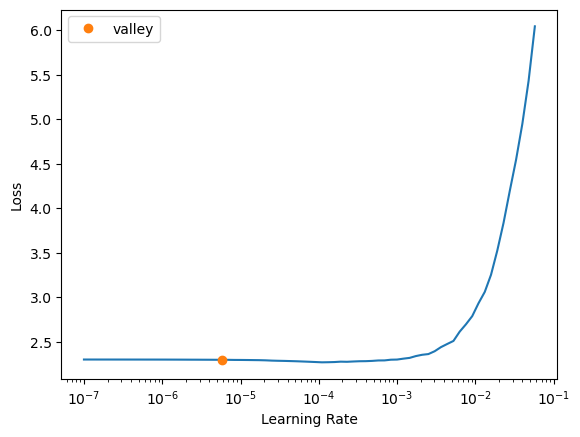

In [6]:
# Using tsai/fastai, create DataLoaders for the features in X_feat.

#batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_feat, y, splits=splits)#, batch_tfms=batch_tfms)
                 
# model is a linear classifier Head
model = build_ts_model(MiniRocketHead,c_out=2*buckets, dls=dls)
                 
# Drop into fastai and use it to find a good learning rate.
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy, cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.239484,2.205152,0.191822,00:16
1,2.223920,2.195446,0.205051,00:15
2,2.227221,2.195483,0.198136,00:16
3,2.217117,2.198177,0.196733,00:15
4,2.219694,2.201718,0.195931,00:15
5,2.211392,2.208955,0.198437,00:15
6,2.209266,2.213432,0.197033,00:15
7,2.200013,2.215667,0.201844,00:15
8,2.195948,2.219450,0.197935,00:15
9,2.198127,2.219014,0.202746,00:14


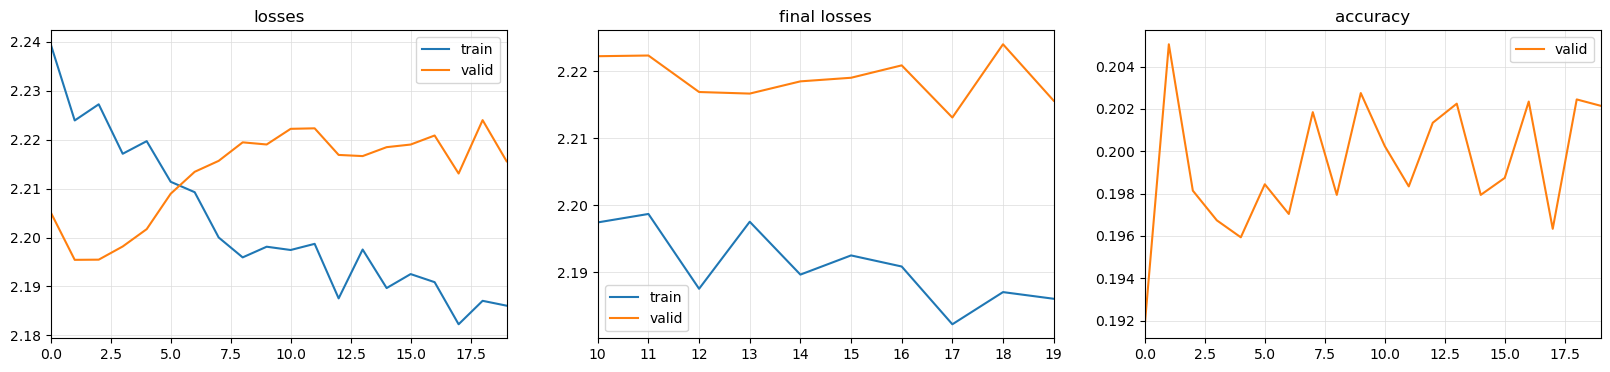

Total time              : 348.598059


348.598059

In [7]:
# As above, use tsai to bring X_feat into fastai, and train.

batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_feat, y, splits=splits)#, batch_tfms=batch_tfms)

model = build_ts_model(MiniRocketHead,c_out=2*buckets, dls=dls)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy, cbs=ShowGraph())

timer.start()
learn.fit_one_cycle(20, 6e-6)
timer.stop()

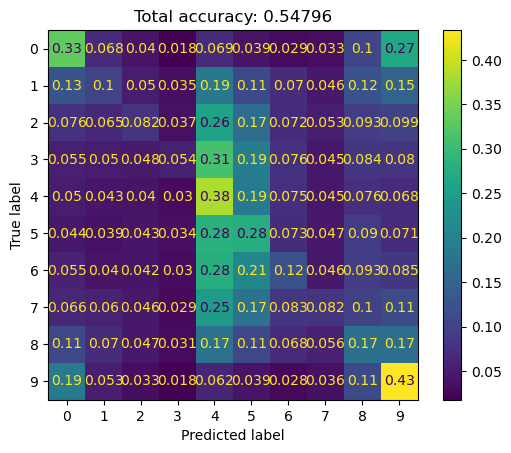

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_x = X_feat[:50000] #Need to be replaced with actual test data
test_y = y[:50000]

learn_curr = learn

preds, _, y_preds = learn_curr.get_X_preds(test_x)

test_binary = [-1 if y < buckets else 1 for y in test_y]
pred_binary = [-1 if y < buckets else 1 for y in y_preds]

accuracy = sum(y1 * y2 > 0 for y1, y2 in zip(pred_binary, test_binary))/len(pred_binary)


disp = ConfusionMatrixDisplay.from_predictions(test_y, y_preds, display_labels=range(2*buckets), normalize = 'true')
plt.title('Total accuracy: '+str(accuracy))
plt.show()

# Conclusion ✅

MiniRocket is a new type of algorithm that is significantly faster than any other method of comparable accuracy (including Rocket), and significantly more accurate than any other method of even roughly-similar computational expense. 

`tsai` supports the 2 variations of MiniRocket introduced in this notebook. A cpu version (that can be used with relatively small datasets, with <10k samples) and a gpu (Pytorch) version that can be used with datasets of any size. The Pytorch version can be used in an offline mode (pre-calculating all features before fitting the model) or in an online mode (calculating features on the fly). 

We believe MiniRocket is a great new tool, and encourange you to try it in your next Time Series Classification or Regression task. 